In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmented-absa-vlsp-2018/datasets/2-VLSP2018-SA-Restaurant-dev.csv
/kaggle/input/segmented-absa-vlsp-2018/datasets/3-VLSP2018-SA-Hotel-test.csv
/kaggle/input/segmented-absa-vlsp-2018/datasets/1-VLSP2018-SA-Restaurant-train.csv
/kaggle/input/segmented-absa-vlsp-2018/datasets/2-VLSP2018-SA-Hotel-dev.csv
/kaggle/input/segmented-absa-vlsp-2018/datasets/3-VLSP2018-SA-Restaurant-test.csv
/kaggle/input/segmented-absa-vlsp-2018/datasets/1-VLSP2018-SA-Hotel-train.csv
/kaggle/input/weight-multitask/Multitask-BiLSTM-Res.weights.h5


# DATA

In [2]:
import warnings
import pandas as pd
import re

# Ignore all warnings
warnings.filterwarnings("ignore")

## Load dataset



In [3]:

# Đường dẫn tới các file
TRAIN_PATH ='//kaggle/input/segmented-absa-vlsp-2018/datasets/1-VLSP2018-SA-Restaurant-train.csv'
VAL_PATH ='/kaggle/input/segmented-absa-vlsp-2018/datasets/2-VLSP2018-SA-Restaurant-dev.csv'
TEST_PATH ='/kaggle/input/segmented-absa-vlsp-2018/datasets/3-VLSP2018-SA-Restaurant-test.csv'

# Đọc các file CSV
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

# Lấy tất cả các tên cột từ cả ba DataFrame
all_columns = set(train_df.columns).union(set(val_df.columns)).union(set(test_df.columns))

all_columns

{'AMBIENCE#GENERAL',
 'DRINKS#PRICES',
 'DRINKS#QUALITY',
 'DRINKS#STYLE&OPTIONS',
 'FOOD#PRICES',
 'FOOD#QUALITY',
 'FOOD#STYLE&OPTIONS',
 'LOCATION#GENERAL',
 'RESTAURANT#GENERAL',
 'RESTAURANT#MISCELLANEOUS',
 'RESTAURANT#PRICES',
 'Review',
 'SERVICE#GENERAL'}

## Preprocess data

### Install library

In [4]:
!pip install underthesea
!pip install --upgrade wandb tensorflow
!pip install tf-models-official


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 72.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR:

In [5]:
import tensorflow as tf

# Kiểm tra xem TensorFlow có nhận diện được GPU không
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU found, running on CPU.")
else:
    print(f"Found {len(gpus)} GPU(s), using GPU.")
    # Chỉ thiết lập bộ nhớ GPU khi chưa khởi tạo TensorFlow
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print("Error:", e)

No GPU found, running on CPU.


### Main

In [6]:
import regex as re
import string
import emoji

from nltk import flatten
import unicodedata
from underthesea import word_tokenize


In [7]:
# 1. Loại bỏ các thẻ HTML
def remove_HTML(text):
    clean = re.compile('<.*?>')
    return re.sub(clean,'', text)

# 2. Chuyển đổi các ký tự Unicode về dạng chuẩn
def convert_unicode(text):
    return unicodedata.normalize('NFC', text)

# 3. Loại bỏ các ký tự kéo dài
def remove_elongated_chars(text):
    replacements = {
       'a':'àáảãạăằắẳẵặâầấẩẫậ',
       'e':'èéẻẽẹêềếểễệ',
       'i':'ìíỉĩị',
       'o':'òóỏõọôồốổỗộơờớởỡợ',
       'u':'ùúủũụưừứửữự',
       'y':'ỳýỷỹỵ',
       'd':'đ',
       'A':'ÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬ',
       'E':'ÈÉẺẼẸÊỀẾỂỄỆ',
       'I':'ÌÍỈĨỊ',
       'O':'ÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢ',
       'U':'ÙÚỦŨỤƯỪỨỬỮỰ',
       'Y':'ỲÝỶỸỴ',
       'D':'Đ'
    }
    
    for char, replacements_str in replacements.items():
        pattern = rf"({char})\1+"
        text = re.sub(pattern, char, text)
    
    pattern = r"(\w)\1+"
    text = re.sub(pattern, r'\1', text)
    return text

# 4. Xử lý các từ phủ định
def handle_negation(text):
    not_words = {"không",'không hề', "chẳng", "chưa", "không phải", "chả", "mất",
                 "thiếu", "đếch", "đéo", "kém", "nỏ", "not",
                 "bớt", "không bao giờ", "chưa bao giờ"}
    not_words = sorted(not_words, key=len, reverse=True)
    pattern = r'\b(?:'+'|'.join(re.escape(word) for word in not_words) + r')\b'
    text = re.sub(pattern,'không', text, flags=re.IGNORECASE)
    return text

# 5. Chuẩn hóa các từ viết tắt thường gặp
def normalize_acronyms(text):
    acronyms = {
       'ô kêi':'ok','okie':'ok','o kê':'ok',
       'okey':'ok','ôkê':'ok','oki':'ok','oke': 'ok','okay':'ok','okê':'ok',
       'tks': u'cám ơn','thks': u'cám ơn','thanks': u'cám ơn','ths': u'cám ơn','thank': u'cám ơn',
       '⭐':'star','*':'star','🌟':'star',
       'kg': u'không','not': u'không', u'kg': u'không','"k': u'không','kh':u'không','kô':u'không','hok':u'không','kp': u'không phải',u'kô': u'không','"ko': u'không', u'ko': u'không', u'k': u'không','khong': u'không', u'hok': u'không',
       'cute': u'dễ thương','vs': u'với','wa':'quá','wá': u'quá','j': u'gì','“':'',
       'sz': u'cỡ','size': u'cỡ', u'đx': u'được','dk': u'được','dc': u'được','đk': u'được',
       'đc': u'được','authentic': u'chuẩn chính hãng',u'aut': u'chuẩn chính hãng', u'auth': u'chuẩn chính hãng','store': u'cửa hàng',
       'shop': u'cửa hàng','sp': u'sản phẩm','gud': u'tốt','god': u'tốt','wel done':'tốt','good': u'tốt','gút': u'tốt',
       'sấu': u'xấu','gut': u'tốt', u'tot': u'tốt', u'nice': u'tốt','perfect':'rất tốt','bt': u'bình thường',
       'time': u'thời gian','qá': u'quá', u'ship': u'giao hàng', u'm': u'mình', u'mik': u'mình',
       'ể':'ể','product':'sản phẩm','quality':'chất lượng','chat':'chất','excelent':'hoàn hảo','bad':'tệ','fresh':'tươi','sad':'tệ',
       'date': u'hạn sử dụng','hsd': u'hạn sử dụng','quickly': u'nhanh','quick': u'nhanh','fast': u'nhanh','delivery': u'giao hàng',u'síp': u'giao hàng',
       'beautiful': u'đẹp tuyệt vời', u'tl': u'trả lời', u'r': u'rồi', u'shopE': u'cửa hàng',u'order': u'đặt hàng',
       'chất lg': u'chất lượng',u'sd': u'sử dụng',u'dt': u'điện thoại',u'nt': u'nhắn tin',u'tl': u'trả lời',u'sài': u'xài',u'bjo':u'bao giờ',
       'thick': u'thích','thik': u'thích', u'sop': u'cửa hàng', u'shop': u'cửa hàng', 
       'fb':'facebook','face':'facebook','very': u'rất',u'quả ng':u'quảng ',
       'dep': u'đẹp',u'xau': u'xấu','delicious': u'ngon', u'hàg': u'hàng', u'qủa': u'quả',
       'iu': u'yêu','fake': u'giả mạo','trl':'trả lời',
       'por': u'tệ','poor': u'tệ','ib':u'nhắn tin','rep':u'trả lời',u'fback':'feedback','fedback':'feedback',
       'max': u'cực kỳ',
       'full':'đầy đủ', 'ful':'đầy đủ'
    }
    words = text.split()
    normalized_text =' '.join([acronyms.get(word.lower(), word) for word in words])
    return normalized_text

# 6. Phân đoạn từ cho tiếng Việt
def word_segmentation(text):
    return word_tokenize(text, format="text")

def process_emojis(text):
    emojis_list = {
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': 'positive ', '👍': 'positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':'positive ',
        '👎': 'negative ', '😣': 'negative ','✨': 'positive ', '❣': 'positive ','☀': 'positive ',
        '♥': 'positive ', '🤩': 'positive ', 'like': 'positive ', ':))': 'positive ', ':)': 'positive ',
        'he he': 'positive ','hehe': 'positive ','hihi': 'positive ', 'haha': 'positive ', 'hjhj': 'positive ',
        ' lol ': 'negative ',' cc ': 'negative ', 'huhu': 'negative ', '><': u'positive ',
        '💌': 'positive ', '🥰': 'positive ', '🙆' : 'positive ', '😅' : 'negative ',
        '🤒' : 'negative ', '🤨' : 'negative ', '🤦' : 'negative ', '😬' :'negative ',
        '🔋' : 'positive ', '💔' : 'negative ', '🤮' : 'negative ', '✋' : 'positive ',
        '🤣': 'positive ', '🖤': 'positive ', '🤤': 'positive ', ':(': 'negative ', '😢': 'negative ',
        '❤': 'positive ', '😍': 'positive ', '😘': 'positive ', '😪': 'negative ', '😊': 'positive ',
        '?': ' ? ', '😁': 'positive ', '💖': 'positive ', '😟': 'negative ', '😭': 'negative ',
        '💯': 'positive ', '💗': 'positive ', '♡': 'positive ', '💜': 'positive ', '🤗': 'positive ',
        '^^': 'positive ', '😨': 'negative ', '☺': 'positive ', '💋': 'positive ', '👌': 'positive ',
        '😖': 'negative ', '😀': 'positive ', ':((': 'negative ', '😡': 'negative ', '😠': 'negative ',
        '😒': 'negative ', '🙂': 'positive ', '😏': 'negative ', '😝': 'positive ', '😄': 'positive ',
        '😙': 'positive ', '😤': 'negative ', '😎': 'positive ', '😆': 'positive ', '💚': 'positive ',
        '✌': 'positive ', '💕': 'positive ', '😞': 'negative ', '😓': 'negative ', '️🆗️': 'positive ',
        '😉': 'positive ', '😂': 'positive ', ':v': 'positive ', '=))': 'positive ', '😋': 'positive ',
        '💓': 'positive ', '😐': 'negative ', ':3': 'positive ', '😫': 'negative ', '😥': 'negative ',
        '😃': 'positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': 'positive ', '🤝': 'positive ', '🎈': 'positive ',
        '😗': 'positive ', '🤔': 'negative ', '😑': 'negative ', '🔥': 'negative ', '🙏': 'negative ',
        '🆗': 'positive ', '😻': 'positive ', '💙': 'positive ', '💟': 'positive ',
        '😚': 'positive ', '❌': 'negative ', '👏': 'positive ', ';)': 'positive ', '<3': 'positive ',
        '🌝': 'positive ',  '🌷': 'positive ', '🌸': 'positive ', '🌺': 'positive ',
        '🌼': 'positive ', '🍓': 'positive ', '🐅': 'positive ', '🐾': 'positive ', '👉': 'positive ',
        '💐': 'positive ', '💞': 'positive ', '💥': 'positive ', '💪': 'positive ',
        '💰': 'positive ',  '😇': 'positive ', '😛': 'positive ', '😜': 'positive ',
        '🙃': 'negative ', '🤑': 'positive ', '🤪': 'positive ','☹': 'negative ',  '💀': 'negative ',
        '😔': 'negative ', '😧': 'negative ', '😩': 'negative ', '😰': 'negative ', '😳': 'negative ',
        '😵': 'negative ', '😶': 'negative ', '🙁': 'negative ', '🎉': 'positive '}
    for emoji, label in emojis_list.items():
        text = text.replace(emoji, f'EMO{label.lower()}' )
        
    text = ' ' .join(text.split())
    return text

# 7. Loại bỏ các ký tự không cần thiết khỏi văn bản
def remove_unnecessary_characters(text):
    text = re.sub(r'\s+', ' ', text)  # Loại bỏ khoảng trắng thừa
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ các ký tự đặc biệt
    return text.strip()

# 8. Kết hợp các hàm để tiền xử lý văn bản
def text_preprocess(text):
    text = remove_HTML(text)
    text = normalize_acronyms(text)
    text = convert_unicode(text)
    text = remove_elongated_chars(text)
    text = handle_negation(text)
    text = process_emojis(text)
    #text = word_segmentation(text)
    text = remove_unnecessary_characters(text)
    return text

In [8]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from official.nlp import optimization
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, GlobalAveragePooling1D
from keras.layers import LSTM, Bidirectional



In [9]:
# Define pre-trained model and tokenizer
PRETRAINED_MODEL = 'vinai/phobert-base'  # Choose your preferred Vietnamese BERT model
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.model_max_length = 256


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [10]:
# Prepare data for TensorFlow
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
BATCH_SIZE = 16
print(MAX_SEQUENCE_LENGTH)

256


In [11]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 1: one_hot = [1, 0, 0, 0] #Pos
            elif sentiment == 2: one_hot = [0, 1, 0, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 1, 0] # Neu
            elif sentiment == 0: one_hot = [0, 0, 0, 1] # None
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')
y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (2961, 12, 4)
Validate outputs: (1290, 12, 4)
Test outputs: (500, 12, 4)


array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [12]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 500
    })
})

In [13]:
print('input_ids of sentence 1484:', raw_datasets['train'][1484])

input_ids of sentence 1484: {'Review': "['Mì ý bò lúc_lắc và nui lúc_lắc .', 'Hơi nhiều dầu_mỡ .']", 'AMBIENCE#GENERAL': 0, 'DRINKS#PRICES': 0, 'DRINKS#QUALITY': 0, 'DRINKS#STYLE&OPTIONS': 0, 'FOOD#PRICES': 0, 'FOOD#QUALITY': 3, 'FOOD#STYLE&OPTIONS': 0, 'LOCATION#GENERAL': 0, 'RESTAURANT#GENERAL': 0, 'RESTAURANT#MISCELLANEOUS': 0, 'RESTAURANT#PRICES': 0, 'SERVICE#GENERAL': 0}


In [14]:
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['Review']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [15]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/1290 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 32899, 2198, 1476, 33626, 6262, 6, 7873, 1111, 33626, 6262, 24716, 36, 14972, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
print('Decode:', tokenizer.decode(tokenized_datasets['train'][1484]['input_ids']))


Decode: <s> Mì ý bò lúc_lắc và nui lúc_lắc Hơi nhiều dầu_mỡ </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [17]:
tokenized_datasets['train']

Dataset({
    features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2961
})

In [18]:


# Now proceed with your dataset and model setup
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=True
)

validation_dataset = tokenized_datasets["val"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=False
)


# Model

In [19]:
topic = train_df.columns[1:]

In [20]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, concatenate
from transformers import TFAutoModel

# BERT Layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL)

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state  

def create_model(optimizer):
    # Define the input layers
    input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')

    # BERT Layer
    bert_layer = BertLayer()([input_ids, attention_mask, token_type_ids])

    # LSTM and Bidirectional Layers
    lstm_layer = LSTM(units=64, return_sequences=False)
    bidirectional_layer = Bidirectional(lstm_layer)
    lstm_output = bidirectional_layer(bert_layer)

    # Output layer for each topic with 4 sentiment classes
    topic_output = []
    for label in topic:
        sentiment_output = Dense(
            units=4,  # 4 classes: neg, neu, pos, none
            activation='softmax',  # softmax for multi-class classification
            name=label.replace('#', '_').replace('&', 'AND')
        )(lstm_output)
        topic_output.append(sentiment_output)

    # Concatenate outputs for all topics
    dense = concatenate(topic_output, axis=-1)

    # Define your model
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)

    # Compile your model with categorical cross-entropy loss
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model


In [21]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 30
# Số bước huấn luyện là số lượng mẫu trong tập dữ liệu, chia cho kích thước lô sau đó nhân
# với tổng số epoch. Lưu ý rằng tf_train_dataset ở đây là tf.data.Dataset theo lô,
# không phải là Hugging Face Dataset, vì vậy len() của nó đã là num_samples // batch_size.
num_train_steps = len(train_dataset) * EPOCHS
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [22]:
num_train_steps

5580

In [23]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [24]:
model = create_model(opt)


tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_type_ids            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 256, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0],  │
│                           │                        │                │ token_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        426,496 │ bert_layer[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ AMBIENCE_GENERAL (Dense)  │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_PRICES (Dense)     │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_QUALITY (Dense)    │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_STYLEANDOPTIONS    │ (None, 4)              │            516 │ bidirectional[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_PRICES (Dense)       │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_QUALITY (Dense)      │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_STYLEANDOPTIONS      │ (None, 4)              │            516 │ bidirectional[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LOCATION_GENERAL (Dense)  │ (None, 4)              │            516 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RESTAURANT_GENERAL        │ (None, 4)              │            516 │ bidirectional[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RESTAURANT_MISCELLANEOUS  │ (None, 4)              │            516 │ bidirectional[0][0]    │
│ (Dense)                   │                        │                │                        │
├──────────────────────

 Total params: 432,688 (1.65 MB)

 Trainable params: 432,688 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Chuyển đổi từ one-hot vector thành scalar
y_scalar = np.argmax(y_train, axis=2)  # Dạng (2961, 12)
y_scalar

array([[3, 3, 3, ..., 3, 3, 3],
       [0, 3, 3, ..., 3, 2, 1],
       [1, 3, 3, ..., 0, 3, 0],
       ...,
       [3, 3, 3, ..., 0, 3, 3],
       [0, 3, 3, ..., 3, 0, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = {}

# Tính trọng số lớp cho từng chủ đề
for i in range(y_scalar.shape[1]):  # Với 12 chủ đề
    y_column = y_scalar[:, i]  # Lấy nhãn scalar của chủ đề i
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_column),
        y=y_column
    )
    class_weights[i] = dict(enumerate(weights))


In [27]:
# Create TensorFlow Datasets
def encode_data(tokenized_datasets, labels):
    return (
        {
            'input_ids': tf.constant(tokenized_datasets['input_ids']),
            'attention_mask': tf.constant(tokenized_datasets['attention_mask']),
            'token_type_ids': tf.constant(tokenized_datasets['token_type_ids'])
        },
        tf.constant(labels)
    )

In [28]:
train_data = encode_data(tokenized_datasets['train'], np.reshape(y_train, (-1, 12*4)))
val_data = encode_data(tokenized_datasets['val'], np.reshape(y_val, (-1, 12*4)))


In [29]:
train_data

({'input_ids': <tf.Tensor: shape=(2961, 256), dtype=int32, numpy=
  array([[    0,  2926,   144, ...,     1,     1,     1],
         [    0,  2926, 33191, ...,     1,     1,     1],
         [    0,    99,   509, ...,     1,     1,     1],
         ...,
         [    0,  2305, 20468, ...,     1,     1,     1],
         [    0, 24326,    23, ...,     1,     1,     1],
         [    0, 30441,  1027, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(2961, 256), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(2961, 256), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

In [30]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(BATCH_SIZE)

In [31]:
import os
import wandb
import tensorflow as tf
import numpy as np
import warnings
import logging
# Set TensorFlow logging level to ERROR to suppress warnings and informational messages
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional method to suppress specific warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Suppress TensorFlow warnings and errors: 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR



In [32]:
import wandb
import os
import tensorflow as tf

# Define the checkpoint path
checkpoint_path = "Multitask-BiLSTM-Resver2.weights.h5"
# Set your WandB API key
wandb.login(key="b9575849263a9312a73f76d71d270c8751628e10")

# Initialize WandB with a unique run ID based on current timestamp
run_id = "2fw9hea1b"
wandb.init(project="multitask-bilstm", id=run_id, resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lavibuu (lavibu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [33]:
class WandbLearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        else:
            lr = lr.numpy()

        # Log the learning rate
        wandb.log({"learning_rate": lr}, step=epoch)

In [34]:
"""import wandb
import numpy as np
import os
import tensorflow as tf

# Định nghĩa early_stop_callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Thiết lập mức độ log của TensorFlow để chỉ hiển thị các lỗi nghiêm trọng
tf.get_logger().setLevel('ERROR')

# Check if checkpoint exists and load weights
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded.")

# Định nghĩa hàm huấn luyện
def train_model(model, train_dataset, val_dataset, epochs=3):
    history = model.fit(
        train_dataset,
        epochs=epochs,  # Huấn luyện cho tất cả epochs
        validation_data=val_dataset,
        callbacks=[
            early_stop_callback,
            model_checkpoint_callback,
            WandbLearningRateLogger(),  # Log learning rate to WandB
        ],
        verbose=1
    )
    for epoch in range(epochs):
            avg_train_loss = history.history['loss'][epoch]
            avg_val_loss = history.history['val_loss'][epoch]

            # Log losses to WandB
            wandb.log({
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "epoch": epoch + 1
            })

            print(f"Epoch {epoch + 1}/{epochs} - Train loss: {avg_train_loss:.4f} - Validation loss: {avg_val_loss:.4f}")

            # Kiểm tra xem callback EarlyStopping có dừng huấn luyện không
            if model.stop_training:
                print("Early stopping triggered")
                break

# Train model
train_model(model, train_dataset, val_dataset, epochs=30)
"""

'import wandb\nimport numpy as np\nimport os\nimport tensorflow as tf\n\n# Định nghĩa early_stop_callback\nearly_stop_callback = tf.keras.callbacks.EarlyStopping(\n    monitor=\'val_loss\',  \n    patience=5,  \n    restore_best_weights=True  \n)\n\nmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=checkpoint_path,\n    save_weights_only=True,\n    monitor=\'val_loss\',\n    mode=\'min\',\n    save_best_only=True,\n    verbose=1\n)\n\n# Thiết lập mức độ log của TensorFlow để chỉ hiển thị các lỗi nghiêm trọng\ntf.get_logger().setLevel(\'ERROR\')\n\n# Check if checkpoint exists and load weights\nif os.path.exists(checkpoint_path):\n    model.load_weights(checkpoint_path)\n    print("Checkpoint loaded.")\n\n# Định nghĩa hàm huấn luyện\ndef train_model(model, train_dataset, val_dataset, epochs=3):\n    history = model.fit(\n        train_dataset,\n        epochs=epochs,  # Huấn luyện cho tất cả epochs\n        validation_data=val_dataset,\n        callbacks=[\n 

In [35]:
import wandb
import numpy as np
import os
import tensorflow as tf

# Định nghĩa early_stop_callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Thiết lập mức độ log của TensorFlow để chỉ hiển thị các lỗi nghiêm trọng
tf.get_logger().setLevel('ERROR')

# Check if checkpoint exists and load weights
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded.")
    # Retrieve the last epoch saved in W&B to continue from there
    last_epoch = wandb.run.summary.get('epoch', 0)
else:
    last_epoch = 0  # If no checkpoint, start from epoch 0

# Định nghĩa hàm huấn luyện
def train_model(model, train_dataset, val_dataset, epochs=3, start_epoch=0):
    # Create a W&B run
    with wandb.init(project="multitask-bilstm") as run:
        # Log initial config
        wandb.config.update({"epochs": epochs, "start_epoch": start_epoch})

        # Train for all epochs starting from start_epoch
        history = model.fit(
            train_dataset,
            epochs=epochs,  # Huấn luyện cho tất cả epochs
            initial_epoch=start_epoch,  # Start from the last epoch
            validation_data=val_dataset,
            callbacks=[
                early_stop_callback,
                model_checkpoint_callback,
                WandbLearningRateLogger(),  # Log learning rate to WandB
            ],
            verbose=1
        )

        # Log the training and validation loss for each epoch
        for epoch in range(start_epoch, epochs):
            avg_train_loss = history.history['loss'][epoch]
            avg_val_loss = history.history['val_loss'][epoch]

            # Log losses to WandB
            wandb.log({
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "epoch": epoch + 1
            })

            print(f"Epoch {epoch + 1}/{epochs} - Train loss: {avg_train_loss:.4f} - Validation loss: {avg_val_loss:.4f}")

            # Kiểm tra xem callback EarlyStopping có dừng huấn luyện không
            if model.stop_training:
                print("Early stopping triggered")
                break

# Train model from last epoch
train_model(model, train_dataset, val_dataset, epochs=100, start_epoch=last_epoch)


Checkpoint loaded.
Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0133 - loss: 34.6310
Epoch 1: val_loss improved from inf to 34.89990, saving model to Multitask-BiLSTM-Resver2.weights.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 1397s 7s/step - accuracy: 0.0133 - loss: 34.6299 - val_accuracy: 0.0093 - val_loss: 34.8999
Epoch 2/100


wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0131 - loss: 34.5588
Epoch 2: val_loss did not improve from 34.89990
186/186 ━━━━━━━━━━━━━━━━━━━━ 1328s 7s/step - accuracy: 0.0131 - loss: 34.5577 - val_accuracy: 0.0078 - val_loss: 34.9454
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0175 - loss: 34.5248
Epoch 3: val_loss improved from 34.89990 to 34.87859, saving model to Multitask-BiLSTM-Resver2.weights.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 1339s 7s/step - accuracy: 0.0175 - loss: 34.5237 - val_accuracy: 0.0093 - val_loss: 34.8786
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0171 - loss: 34.4465
Epoch 4: val_loss improved from 34.87859 to 34.86662, saving model to Multitask-BiLSTM-Resver2.weights.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 1330s 7s/step - accuracy: 0.0171 - loss: 34.4455 - val_accuracy: 0.0140 - val_loss: 34.8666
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0219 - loss: 34.4219
Epoch 5: val_loss did not improve from 34

epoch,▁
learning_rate,██▇▇▆▆▅▅▄▄▄▃▃▂▂▁▁
train_loss,▁
val_loss,▁
epoch,1
learning_rate,2e-05
train_loss,34.43038
val_loss,34.8999


In [36]:
test_data = encode_data(tokenized_datasets['test'], np.reshape(y_test, (-1, 12*4)))
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)

In [37]:
# Evaluate the model on the test dataset
test_loss= model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.0085 - loss: 39.0956


# Reload the model

In [38]:
reloaded_model = create_model(opt)
reloaded_model.load_weights('/kaggle/working/Multitask-BiLSTM-Resver2.weights.h5')


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_type_ids            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_1 (BertLayer)  │ (None, 256, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0],  │
│                           │                        │                │ token_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │        426,496 │ bert_layer_1[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ AMBIENCE_GENERAL (Dense)  │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_PRICES (Dense)     │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_QUALITY (Dense)    │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DRINKS_STYLEANDOPTIONS    │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_PRICES (Dense)       │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_QUALITY (Dense)      │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FOOD_STYLEANDOPTIONS      │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LOCATION_GENERAL (Dense)  │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RESTAURANT_GENERAL        │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RESTAURANT_MISCELLANEOUS  │ (None, 4)              │            516 │ bidirectional_1[0][0]  │
│ (Dense)                   │                        │                │                        │
├──────────────────────

 Total params: 1,298,065 (4.95 MB)

 Trainable params: 432,688 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 865,377 (3.30 MB)

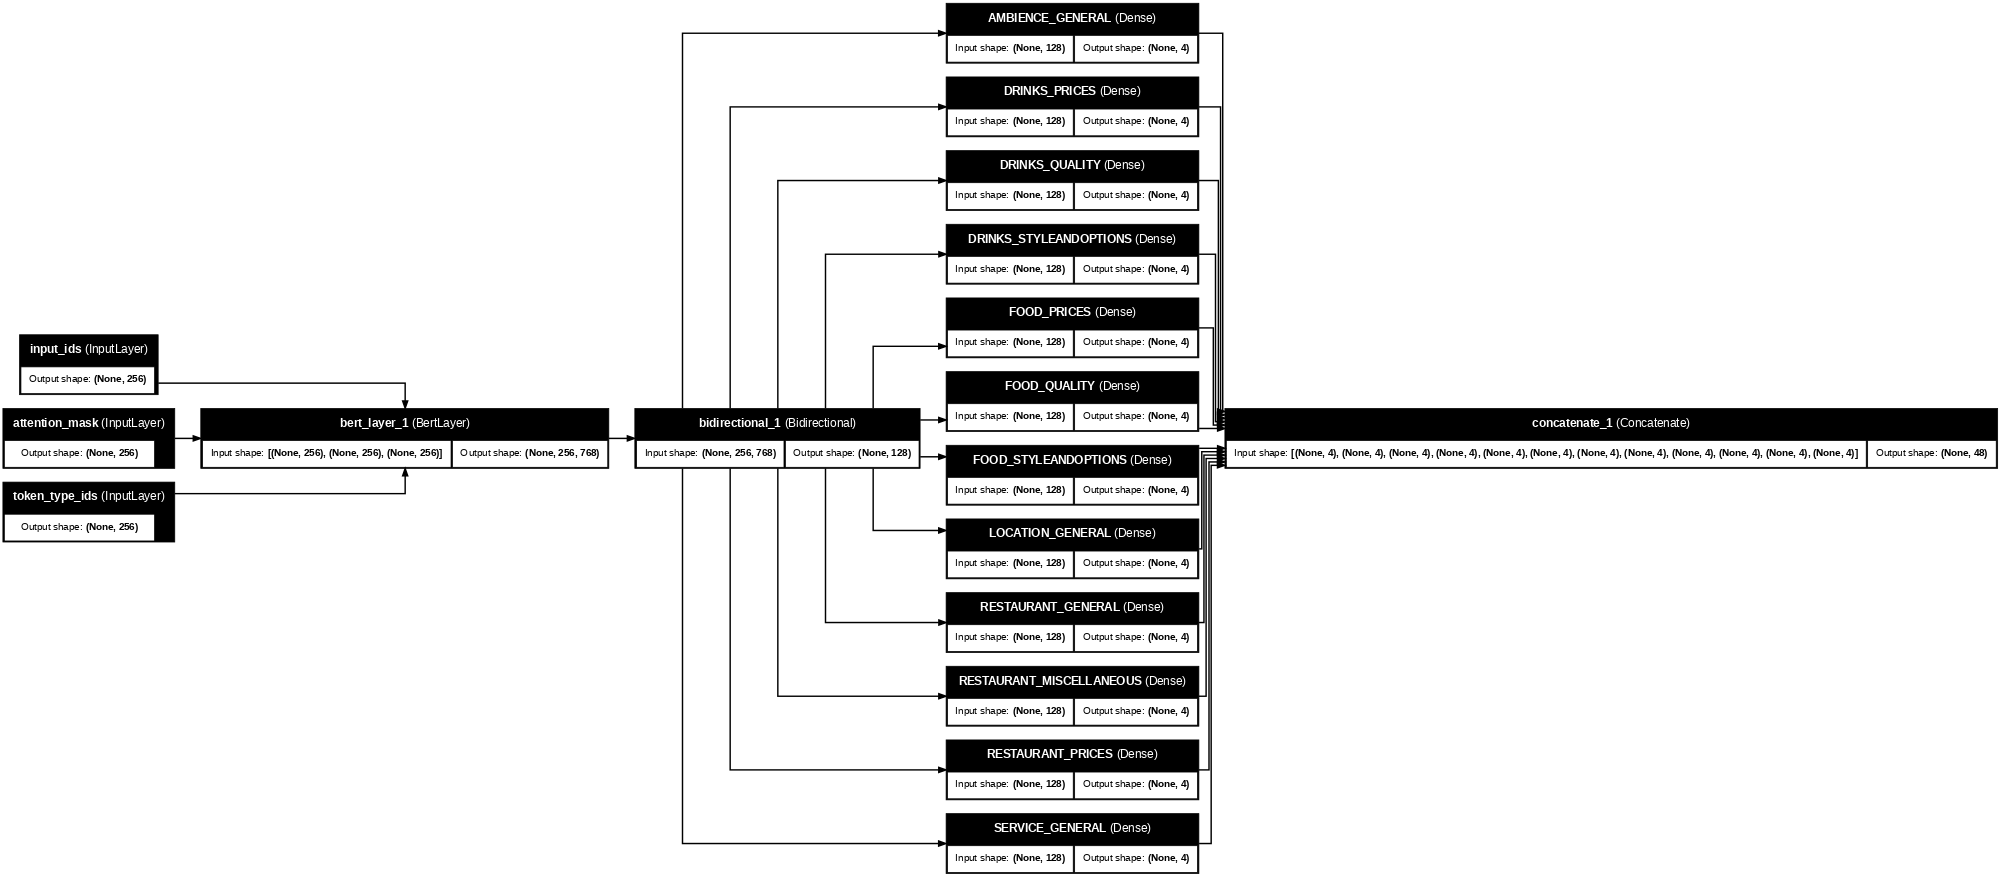

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file='architecture.png', rankdir='LR', dpi=52, show_shapes=True, show_layer_names=True)

# Prediction

In [40]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[3, 2, 0, ..., 3, 3, 3],
       [3, 3, 0, ..., 2, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 0],
       [0, 3, 0, ..., 3, 3, 3]])

In [41]:
replacements = {3: None, 0: 'positive', 1: 'negative', 2: 'neutral'}
categories = test_df.columns[1:]

In [42]:
def print_acsa_pred(sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: print(f'=> {category},{sentiment}')

In [43]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    res = []
    for i in range(len(y_pred)):
        y_pred1 = np.reshape(y_pred[i], (-1, y_train.shape[1]))
        res.append(np.argmax(np.reshape(y_pred1, (-1, 4)),axis=-1))
    return res # sentiment values (position that have max value)


In [44]:
def prediction(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred1 = np.reshape(y_pred, (-1, 4))
    print(y_pred1)
    return np.argmax(y_pred1,axis=-1) # sentiment values (position that have max value)

# Report

In [45]:
y_pred = predict(reloaded_model, test_dataset, BATCH_SIZE, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step


In [46]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])
     

In [47]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                          precision    recall  f1-score   support

                             0.6362    0.6087    0.6222      1669
        AMBIENCE#GENERAL     0.8033    0.7555    0.7787       319
           DRINKS#PRICES     0.9440    1.0000    0.9712       472
          DRINKS#QUALITY     0.8938    1.0000    0.9439       446
    DRINKS#STYLE&OPTIONS     0.9198    1.0000    0.9582       459
             FOOD#PRICES     0.7880    0.7796    0.7838       372
            FOOD#QUALITY     0.2909    0.1649    0.2105        97
      FOOD#STYLE&OPTIONS     0.5442    0.4819    0.5112       166
        LOCATION#GENERAL     0.8866    0.8784    0.8825       436
      RESTAURANT#GENERAL     0.7113    0.5763    0.6367       295
RESTAURANT#MISCELLANEOUS     0.8838    1.0000    0.9383       441
       RESTAURANT#PRICES     0.9120    1.0000    0.9540       456
         SERVICE#GENERAL     0.8110    0.7957    0.8033       372

                accuracy                         0.7943      6000
        

In [48]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = [item for sublist in y_pred for item in sublist]
target_names = list(map(str, replacements.values()))

In [49]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.6362    0.6087    0.6222      1669
    positive     0.1818    0.0126    0.0235       159
    negative     0.4354    0.1997    0.2738       591
     neutral     0.7726    0.8891    0.8268      3581

    accuracy                         0.7200      6000
   macro avg     0.5065    0.4275    0.4366      6000
weighted avg     0.6858    0.7200    0.6941      6000



In [50]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [51]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                                   precision    recall  f1-score   support

            AMBIENCE#GENERAL,None     0.7164    0.7837    0.7485       245
        AMBIENCE#GENERAL,negative     1.0000    0.0000    0.0000        26
         AMBIENCE#GENERAL,neutral     0.3438    0.2292    0.2750        48
        AMBIENCE#GENERAL,positive     0.6100    0.6740    0.6404       181
               DRINKS#PRICES,None     0.8480    1.0000    0.9177       424
           DRINKS#PRICES,negative     1.0000    0.0000    0.0000         3
            DRINKS#PRICES,neutral     1.0000    0.0000    0.0000        45
           DRINKS#PRICES,positive     1.0000    0.0000    0.0000        28
              DRINKS#QUALITY,None     0.8597    1.0000    0.9246       429
          DRINKS#QUALITY,negative     1.0000    0.0000    0.0000         6
           DRINKS#QUALITY,neutral     1.0000    0.0000    0.0000        11
          DRINKS#QUALITY,positive     1.0000    0.0185    0.0364        54
        DRINKS#STYLE&OPT

In [52]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [53]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.771148,0.772392,0.768801,0.794333
Polarity Detection,0.506516,0.427531,0.436569,0.720000
Aspect + Polarity,0.691602,0.310228,0.298130,0.720000


In [54]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}
pred = prediction(reloaded_model, tf.data.Dataset.from_tensor_slices(features))
print_acsa_pred(pred)

Enter your sentence:  nhà hàng này đẹp


[[0.2153495  0.02924977 0.03267361 0.72272706]
 [0.02997182 0.01662297 0.00559298 0.9478122 ]
 [0.00738135 0.01121628 0.01166373 0.96973866]
 [0.0075945  0.00751626 0.0030656  0.9818236 ]
 [0.23071592 0.11873181 0.05446569 0.5960866 ]
 [0.3267594  0.05395284 0.10278405 0.51650375]
 [0.07203335 0.02298104 0.10306323 0.8019224 ]
 [0.0143054  0.01058289 0.08713058 0.88798106]
 [0.00949946 0.01278291 0.02054237 0.9571752 ]
 [0.01280348 0.01198126 0.00526671 0.9699486 ]
 [0.06617661 0.00711572 0.05024454 0.8764632 ]
 [0.22150084 0.02204058 0.03336956 0.723089  ]]


# 



''''''cvggFvPrediction txt

In [55]:
df = pd.read_csv("/kaggle/input/segmented-absa-vlsp-2018/datasets/3-VLSP2018-SA-Restaurant-test.csv")

In [56]:
def save_predictions_to_txt(sentences, y_pred, categories, replacements, output_filename):
    with open(output_filename, 'w', encoding='utf-8') as f:
        for i, (sentence, pred) in enumerate(zip(sentences, y_pred)):
            f.write(f"#{i+1}\n")
            f.write(f"{sentence}\n")
            
            sentiments = [replacements.get(x, 'None') for x in pred]  
            
            result = []
            for category, sentiment in zip(categories, sentiments):
                if sentiment:
                    result.append(f'{{{category},{sentiment}}}')
                
            f.write(', '.join(result) + "\n\n")  

# Preprocess sentences to remove " và "
sentences = [sentence.replace("['", "").replace("']", "") for sentence in raw_datasets['test']['Review']]

replacements = {3: None, 0: 'positive', 1: 'negative', 2: 'neutral'}
categories = test_df.columns[1:].tolist()  

# Lưu kết quả vào file .txt
save_predictions_to_txt(sentences, y_pred, categories, replacements, 'predictions.txt')


In [57]:

# Tạo hàm xuất dữ liệu
def save_labels_to_txt(df, output_filename):
    # Các cột chứa nhãn
    categories = df.columns[1:]  # Bỏ cột đầu tiên (Review)
    
    with open(output_filename, 'w', encoding='utf-8') as f:
        for i, row in df.iterrows():
            # Làm sạch chuỗi Review
            cleaned_review = row['Review'].replace("['", "").replace("']", "")
            
            f.write(f"#{i+1}\n")
            f.write(f"{cleaned_review}\n")
            
            # Lấy các nhãn và giá trị tương ứng
            result = []
            for category in categories:
                sentiment = row[category]
                if sentiment != 3:  # Loại bỏ các nhãn có giá trị là 3 (None)
                    replacements = {0: 'positive', 1: 'negative', 2: 'neutral'}
                    sentiment_label = replacements.get(sentiment, 'None')
                    result.append(f'{{{category},{sentiment_label}}}')
            
            f.write(', '.join(result) + "\n\n")  # Ghi nhãn vào file

# Xuất file label.txt
save_labels_to_txt(df, "labels.txt")
